In [1]:
#| default_exp dataset

Dataset URL: https://datasetninja.com/dataset-of-annotated-food-crops-and-weed-images


# References:

- https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html - **stratification**
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [2]:
#|export
from pathlib import Path
import os
import cv2
import json
import IPython
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randint
from PIL import Image

from skimage import data, exposure

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

import numpy as np

# Dataset exploration

In [3]:
#|export
ds_dir = Path("../data")
ds_dir.absolute()

PosixPath('/home/master/dev/demokritos/ml_assignments/autofarm_assignment/notebooks/../data')

In [4]:
# Check uniformity in images
ann_ds = os.listdir(ds_dir / "ann")
import json
for each_f in ann_ds:
    with open(os.path.join(ds_dir, f"ann/{each_f}")) as f:
#         print(f"File: {os.path.join(ds_dir.absolute(), f'ann/{each_f}')}")
        d = str(json.load(f))
        if ("weed" in d) and ("crop" in d):
            raise Exception(f"Weed and Crop in => {each_f}") 

In [5]:
#|export
def create_image_file_list(ds_dir):
    imgs_files = os.listdir(ds_dir.absolute() / "img")
    imgs_files_path = ds_dir / "img"

    imgs_ds = []
    for f in imgs_files:
        imgs_ds.append(os.path.join(ds_dir, f"img/{f}"))
    imgs_ds.sort()
    return imgs_ds

In [6]:
imgs_ds = create_image_file_list(ds_dir)
imgs_ds;

In [7]:
#|export
def create_labels_file_list(ds_dir):
    lbls_files = os.listdir(ds_dir.absolute() / "ann")
    lbls_files_path = ds_dir / "ann"

    lbls_ds = []
    for f in lbls_files:
        lbls_ds.append(os.path.join(ds_dir, f"ann/{f}"))
    lbls_ds.sort()
    return lbls_ds

In [8]:
lbls_ds = create_labels_file_list(ds_dir)
lbls_ds;

In [9]:
#|export
def create_dataset_list(ds_dir=ds_dir):
    images_list = create_image_file_list(ds_dir)
    labels_list = create_labels_file_list(ds_dir)
    # Create dataset list[<img file>, <label>]
    ds = []
    for img, lbl in zip(images_list, labels_list):
        with open(lbl) as f:
            l = ""
            d = str(json.load(f))
            if "weed" in d:
                l = "weed"
            elif "crop" in d:
                l = "crop"
            ds.append([img, l])
    return ds

In [31]:
ds = create_dataset_list()
ds;

In [11]:
#|export
def print_ds_info(ds):
    # How many of each {weed, crop}
    nof_weeds = len([row[1] for row in ds if row[1] == "weed"])
    nof_crops = len([row[1] for row in ds if row[1] == "crop"])
    print(f"Nof weed samples: {nof_weeds}")
    print(f"Nof crop samples: {nof_crops}")

In [12]:
print_ds_info(ds)

Nof weed samples: 1116
Nof crop samples: 60


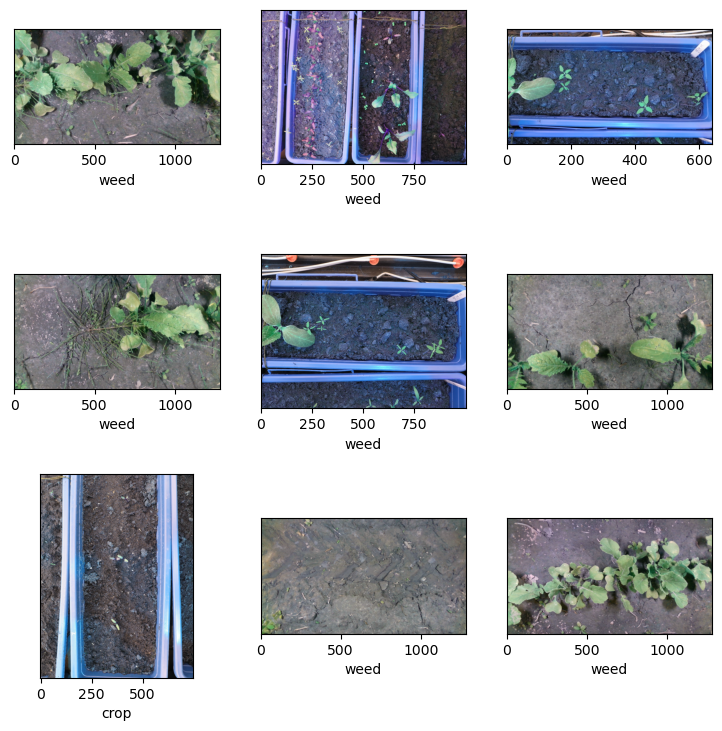

In [13]:
nof_cols, nof_rows = 3, 3
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(nof_cols*3, nof_rows*3))

for ax in axes.flatten():
    ax.get_yaxis().set_ticks([])
    record = randint(0, len(ds))
    ax.set_xlabel(xlabel=ds[record][1])
    ax.imshow(cv2.imread(ds[record][0]))

Determine min resolution from images.

In [50]:
#|export
min_width, min_height = 2000, 2000

def find_min_dim(ds):
    min_width, min_height = 2000, 2000
    for each_img in ds:
        img = Image.open(each_img[0])
        min_width = min(min_width, img.size[0])
        min_height = min(min_height, img.size[1])

    print(f"Minimum resolution: {min_width, min_height}")
    return min_width, min_height

In [33]:
min_width, min_height = find_min_dim()

Minimum resolution: (360, 360)


### Notes:

**Dataset imbalance**: More weeds than crops.

**Minimum resolution**: Have to resize all images to match min resolution - uniformity.